In [22]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
import time
import random
import pandas as pd
from array import *

from scipy import signal
from scipy import misc
from scipy.spatial import distance
from skimage import measure
from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs

In [23]:
def random_color():
    levels = range(32,256,32)
    return tuple(random.choice(levels) for _ in range(3))

In [24]:
img = []
img4 = []
img_orig = []

### Load image

##### Insert white border around image

In [25]:
img = cv2.imread("map.png", cv2.IMREAD_GRAYSCALE);
backtorgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB);
img = backtorgb.dot([0.33,0.33,0.33])

(my,mx)=img.shape
img[0,:]=255
img[:,0]=255
img[my-1,:]=255
img[:,mx-1]=255

img_orig = img.copy()

image_data = np.stack((backtorgb[:,:,0],backtorgb[:,:,1],backtorgb[:,:,2]), axis=2)

### Process Image to find middle point between tracks

##### Difference between subsequent dilations

In [26]:
difftmp = np.array([[1,1,1],[1,0,1],[1,1,1]])
kernel = np.ones((3,3),np.uint8)
img4 = np.zeros_like(img)*0
clas = True
while clas == True:
    img2 = cv2.dilate(img,kernel,iterations = 1)
    img3 = img2-img
    if np.sum(img3)==0:
        break
    
    ### Calculate number of white pixels around this pixel
    img4 = img4+(signal.convolve2d(img3,difftmp, boundary='symm', mode='same')/255>4)*255
    
    image_data = np.stack((img3+img4,img3+img_orig,img3), axis=2)
    img = img2.copy()
image_data = np.stack((img4,img4+img3,img4), axis=2)

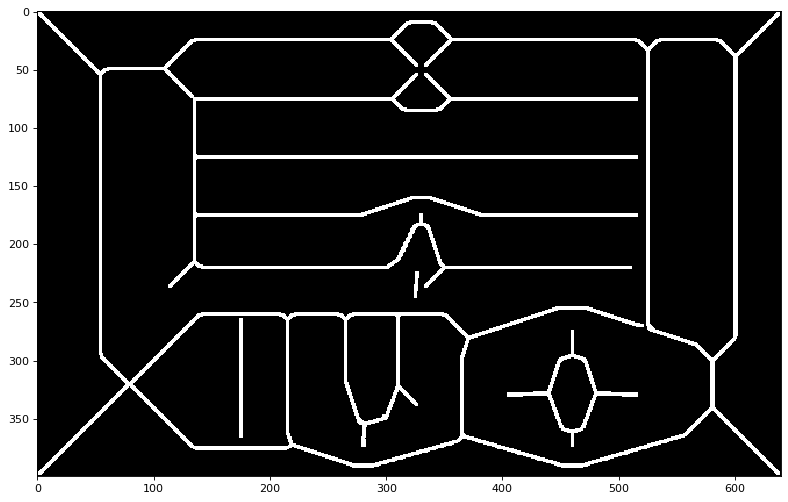

In [35]:
dst = image_data.copy()

kernel = np.ones((3,3),np.uint8)
img4 = cv2.dilate(img4,kernel,iterations = 1)

cv2.imwrite("mapout.png",img)

figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(img4, cmap='gray', vmin=0, vmax=255)
plt.show()

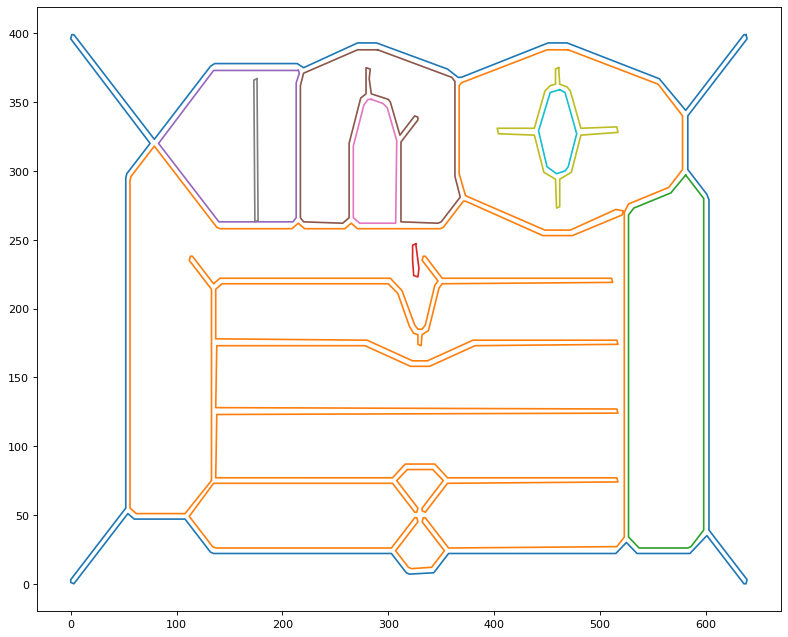

In [41]:
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
contours = measure.find_contours(img4, 1.2)
f_points=[]
for n, contour in enumerate(contours):
    appr_s = approximate_polygon(contour, tolerance=1.2)
    for i in appr_s:
        f_points.append((int(i[1]), int(i[0])))
    plt.plot(appr_s[:,1],appr_s[:,0])
summ_points = f_points.copy()

In [37]:
clus_points = []
while len(summ_points)>0:
    #Take a sample point
    this_point = summ_points[0]

    ## take a point in list
    (x,y) = this_point
    
    ## find all points close 7pixel radius from first pixel
    xx=[]
    yy=[]
    near_points = []
    for sp in summ_points:
        (a,b) = sp
        if ((a-x)**2 + (b-y)**2)<55: #5 pixel distance
            near_points.append(sp)
            xx.append(a)
            yy.append(b)
    
    ## Store mid-point
    mx = int(sum(xx)/len(xx))
    my = int(sum(yy)/len(yy))
    clus_points.append([mx,my])
    
    ## remove all points from remaining list
    for np in near_points:
        summ_points.remove(np)


In [38]:
contours2 = []

for n, contour in enumerate(contours):
    appr_s = approximate_polygon(contour, tolerance=1.2)
    cnt2=[]
    
    for i in appr_s:
        [y,x] = i
        tp = []
        for cp in clus_points:
            (a,b) = cp
            if ((a-x)**2 + (b-y)**2)<55: #5 pixel distance
                tp=[b,a]
                break
        
        cnt2.append(tp)
    
    contours2.append(cnt2)

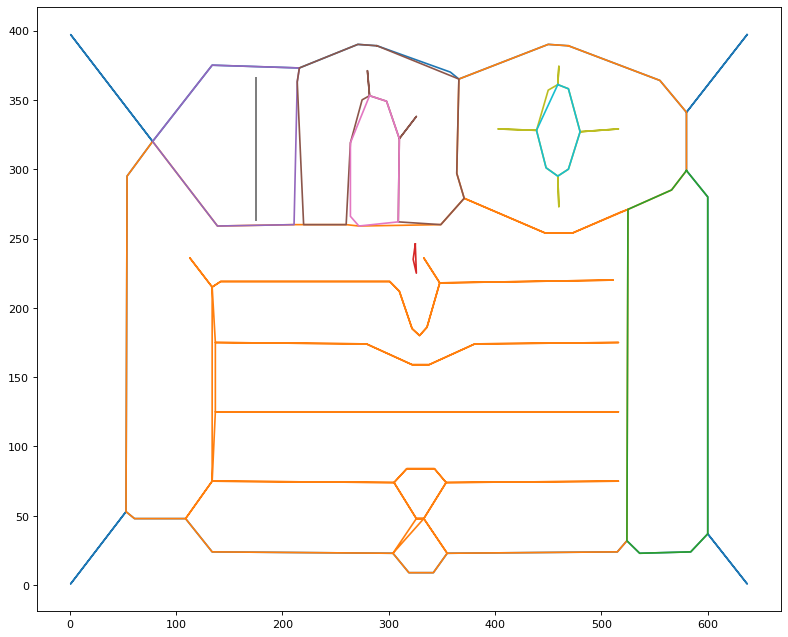

In [39]:
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

for cnt in contours2:
    x=[]
    y=[]
    for sp in cnt:
        [yy,xx]=sp
        x.append(xx)
        y.append(yy)
    plt.plot(x,y)

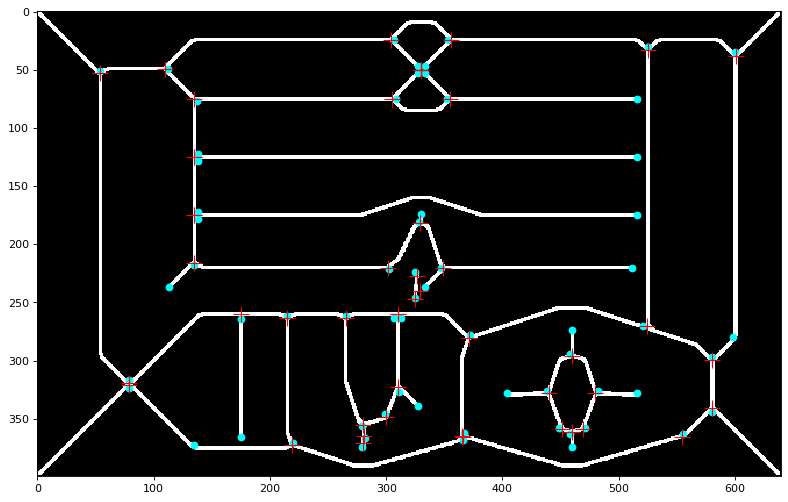

In [17]:
from skimage import data
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse

coords = corner_peaks(corner_harris(img4), min_distance=5)
coords_subpix = corner_subpix(img4, coords, window_size=13)

figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(img4, cmap=plt.cm.gray)

plt.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o', linestyle='None', markersize=6)
plt.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
plt.show()

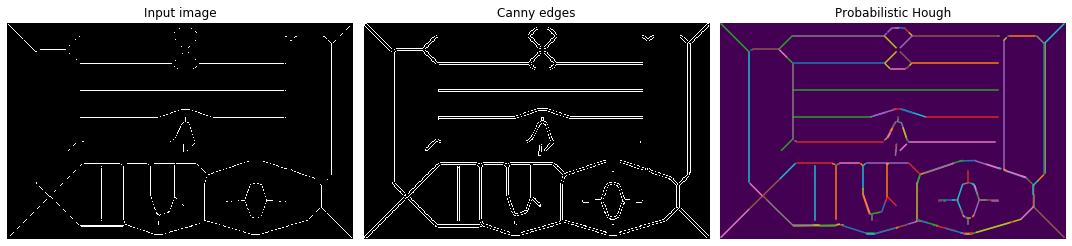

In [33]:
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage import data
# Line finding using the Probabilistic Hough Transform
image = img4.copy()
lines = probabilistic_hough_line(image, threshold=10, line_length=2,
                                 line_gap=3)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=plt.cm.gray)
ax[1].set_title('Canny edges')

ax[2].imshow(edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

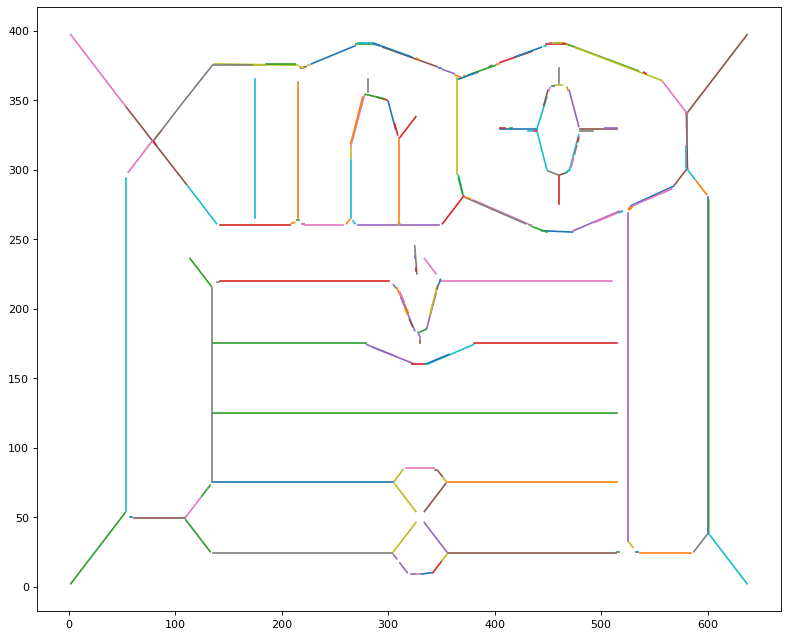

In [34]:
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))